# Predicting No-Shows in Hospitals
In this notebook I look at the ["Medical Appointment No Shows" dataset](https://www.kaggle.com/joniarroba/noshowappointments) on www.kaggle.com
After cleaning the data, I will use Machine Learning models to predict future no shows.

# Step 1: Data Wrangling
After reading in my data, I'm going to look for missing values and invalid entries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline

In [2]:
df_raw = pd.read_csv('../input/noshowappointments/KaggleV2-May-2016.csv')

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Evidently there are no missing values.

### Clean up datatypes
Now I check for mismatched datatypes and convert each category appropriately.

In [4]:
# PatientId should be int64, not float64
df_raw['PatientId'] = df_raw['PatientId'].astype('int64')

# Convert ScheduledDay and AppointmentDay to datetime64[ns]
df_raw['ScheduledDay'] = pd.to_datetime(df_raw['ScheduledDay']).dt.date.astype('datetime64[ns]')
df_raw['AppointmentDay'] = pd.to_datetime(df_raw['AppointmentDay']).dt.date.astype('datetime64[ns]')

In [5]:
# check the head of dataset
df_raw.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Check for typos

In [6]:
# rename typo columns
df_raw.rename(columns={"Hipertension": "Hypertension","Handcap":"Handicap",
                      "SMS_received": "SMSReceived", "No-show": "NoShow"},inplace=True)

In [7]:
# check for typos
print(sorted(df_raw['Neighbourhood'].unique()))

['AEROPORTO', 'ANDORINHAS', 'ANTÔNIO HONÓRIO', 'ARIOVALDO FAVALESSA', 'BARRO VERMELHO', 'BELA VISTA', 'BENTO FERREIRA', 'BOA VISTA', 'BONFIM', 'CARATOÍRA', 'CENTRO', 'COMDUSA', 'CONQUISTA', 'CONSOLAÇÃO', 'CRUZAMENTO', 'DA PENHA', 'DE LOURDES', 'DO CABRAL', 'DO MOSCOSO', 'DO QUADRO', 'ENSEADA DO SUÁ', 'ESTRELINHA', 'FONTE GRANDE', 'FORTE SÃO JOÃO', 'FRADINHOS', 'GOIABEIRAS', 'GRANDE VITÓRIA', 'GURIGICA', 'HORTO', 'ILHA DAS CAIEIRAS', 'ILHA DE SANTA MARIA', 'ILHA DO BOI', 'ILHA DO FRADE', 'ILHA DO PRÍNCIPE', 'ILHAS OCEÂNICAS DE TRINDADE', 'INHANGUETÁ', 'ITARARÉ', 'JABOUR', 'JARDIM CAMBURI', 'JARDIM DA PENHA', 'JESUS DE NAZARETH', 'JOANA D´ARC', 'JUCUTUQUARA', 'MARIA ORTIZ', 'MARUÍPE', 'MATA DA PRAIA', 'MONTE BELO', 'MORADA DE CAMBURI', 'MÁRIO CYPRESTE', 'NAZARETH', 'NOVA PALESTINA', 'PARQUE INDUSTRIAL', 'PARQUE MOSCOSO', 'PIEDADE', 'PONTAL DE CAMBURI', 'PRAIA DO CANTO', 'PRAIA DO SUÁ', 'REDENÇÃO', 'REPÚBLICA', 'RESISTÊNCIA', 'ROMÃO', 'SANTA CECÍLIA', 'SANTA CLARA', 'SANTA HELENA', 'SANTA

Looks clean, so I check other categories

In [8]:
# Check Age
print(sorted(df_raw['Age'].unique()))

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]


In [9]:
df_raw[df_raw['Age'] == -1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
99832,465943158731293,5775010,F,2016-06-06,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No


In [10]:
df_raw[df_raw['Age'] == 115]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
63912,31963211613981,5700278,F,2016-05-16,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,31963211613981,5700279,F,2016-05-16,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,31963211613981,5562812,F,2016-04-08,2016-05-16,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,31963211613981,5744037,F,2016-05-30,2016-05-30,115,ANDORINHAS,0,0,0,0,1,0,No
97666,748234579244724,5717451,F,2016-05-19,2016-06-03,115,SÃO JOSÉ,0,1,0,0,0,1,No


* "Age" column has negative value and anomalous entries of 115. These entries are too far-removed from the rest of dataset. A Google search has confirmed that there were no 115-year-olds alive in Brazil at the timestamps stated. See reference [1] for confirmation.
* I will remove these entries.

In [11]:
# Remove erroneous entries
df_raw = df_raw[(df_raw['Age'] < 115) & (df_raw['Age'] > 0)]

* "PatientId" and "AppointmentID" columns are random system generated numbers. I will delete these.

In [12]:
df_raw = df_raw.drop(['PatientId','AppointmentID'],axis=1)

* Now I clean up "ScheduledDay" and "AppointmentDay" columns

In [13]:
df_raw['ScheduledMonth'] = df_raw['ScheduledDay'].dt.month
df_raw['ScheduledDayofWeek'] = df_raw['ScheduledDay'].dt.day_name()
df_raw['ScheduledHour'] = df_raw['ScheduledDay'].dt.hour

In [14]:
df_raw['AppointmentMonth'] = df_raw['AppointmentDay'].dt.month
df_raw['AppointmentDayofWeek'] = df_raw['AppointmentDay'].dt.day_name()
df_raw['AppointmentHour'] = df_raw['AppointmentDay'].dt.hour

# Step 2: EDA
* Time for some Exploratory Data Analysis.

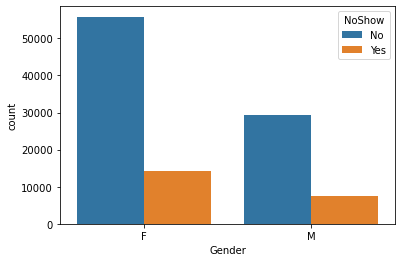

In [15]:
sns.countplot(x='Gender', hue='NoShow', data=df_raw)

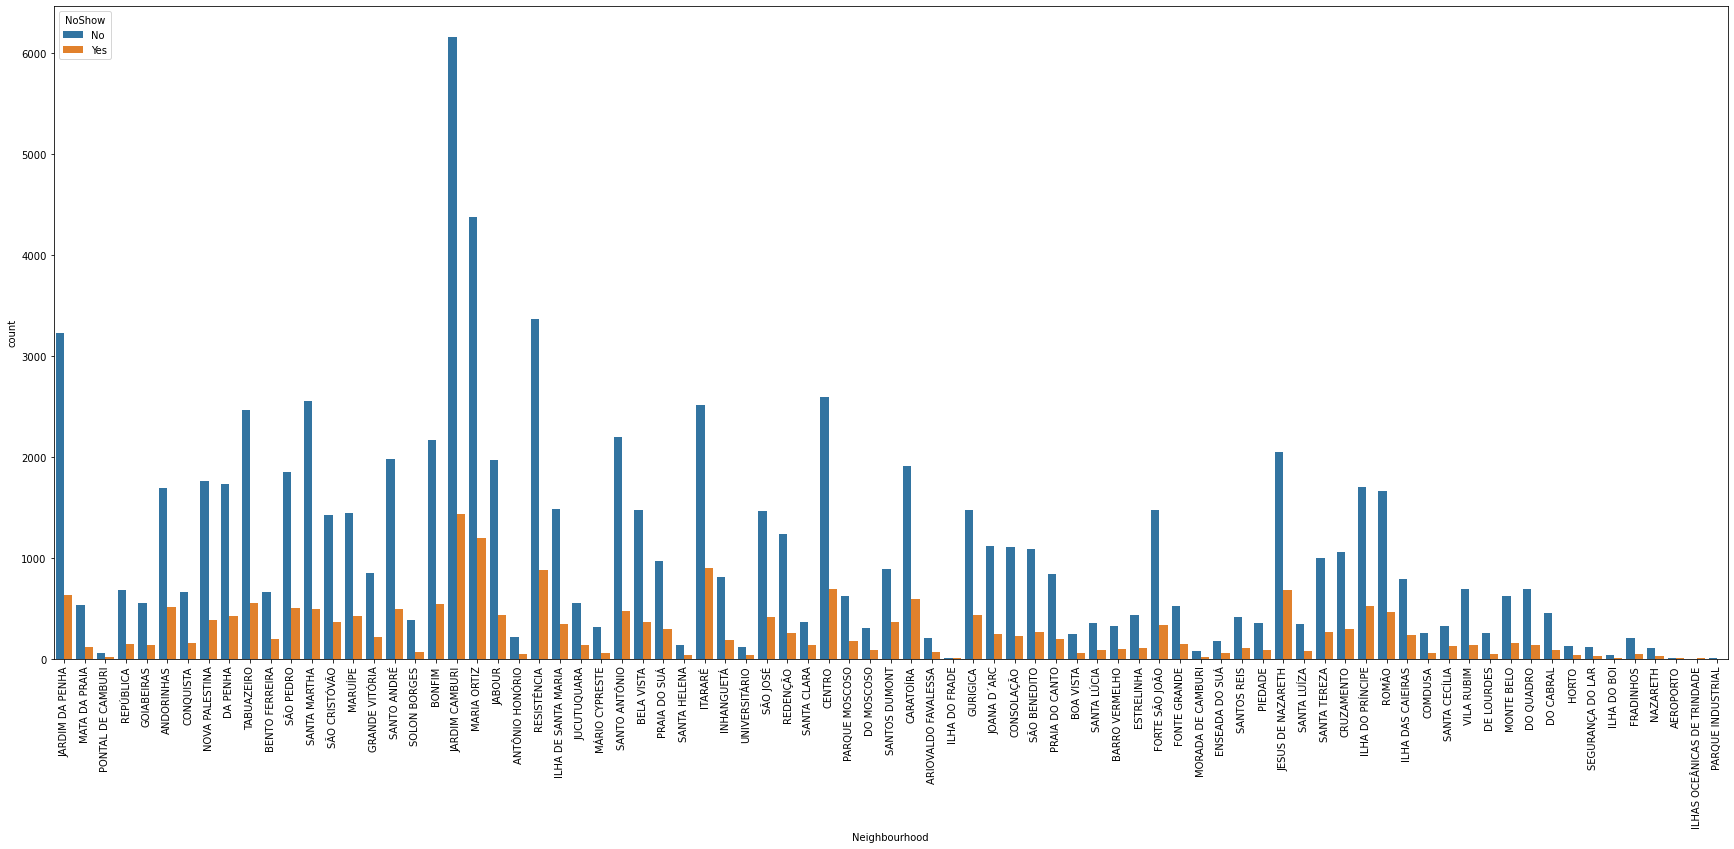

In [16]:
plt.figure(figsize=(30,12))
fig = sns.countplot(x='Neighbourhood',hue='NoShow',data=df_raw)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);

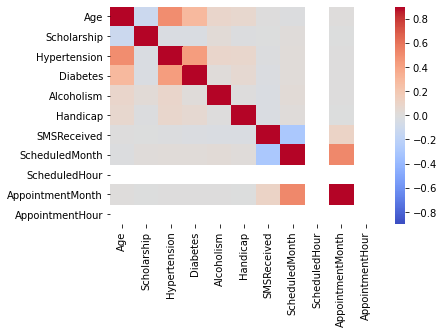

In [17]:
sns.heatmap(df_raw.corr(), vmin=-0.9, vmax=0.9,cmap='coolwarm')

# Step 3: Preprocessing
* Next I prepare data for modelling, creating logical variables and dropping redundant features

In [18]:
df_raw['AppointmentDayofWeek'] = df_raw['AppointmentDay'].dt.weekday
df_raw['ScheduledDayofWeek'] = df_raw['ScheduledDay'].dt.weekday

### Get dummy variables
Now I convert non-numeric variables to logical variables

In [19]:
df_raw['NoShow'] = pd.get_dummies(df_raw['NoShow'])['Yes']

In [20]:
no_show = len(df_raw[df_raw['NoShow'] == 1])
print(f'No-shows: {no_show}')

total = len(df_raw)
print(f'Percentage no-show: {(no_show/total) * 100}')

No-shows: 21677
Percentage no-show: 20.262287113720063


* To help with following plots, I now create a logical variable for gender

In [21]:
# skewed towards female entries
print(f"Gender entries: {df_raw['Gender'].unique()}")
print(df_raw['Gender'].describe())
df_raw['Male'] = pd.get_dummies(df_raw['Gender'])['M']
      
df_raw = df_raw.drop('Gender',axis=1)

Gender entries: ['F' 'M']
count     106982
unique         2
top            F
freq       70113
Name: Gender, dtype: object


In [22]:
# get dummy variables for neighbourhood
neighbourhoods = pd.get_dummies(df_raw['Neighbourhood'])

# join dummy neighbourhood columns and drop string neighbourhood column
df_raw = df_raw.join(neighbourhoods).drop('Neighbourhood',axis=1)

### Drop redundant variables

* Now I drop the "AppointmentDay" "ScheduledDay" columns, as we have no more use for these

In [23]:
df = df_raw.drop(['AppointmentDay','ScheduledDay'],axis=1)

## Standardise Variables
Lastly, I'm going to standardise the variables to prepare data for modelling.

In [24]:
# import StandardScaler from Scikit learn
from sklearn.preprocessing import StandardScaler

# create StandardScaler object
scaler = StandardScaler()

# fit scaler to features
scaler.fit(df.drop(['NoShow'],axis=1))

StandardScaler()

In [25]:
# use .transform() to transform features to scaled version
scaled_features = scaler.transform(df.drop('NoShow',axis=1))

In [26]:
df_feat = pd.DataFrame(scaled_features)
df_feat.head()

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,1.054628,-0.335248,1.976722,-0.283197,-0.180071,-0.139861,-0.691153,-1.153382,1.555744,0.0,...,-0.069888,-0.036199,-0.065138,-0.113092,-0.130262,-0.133272,-0.149735,-0.170409,-0.037596,-0.088371
1,0.787493,-0.335248,-0.505888,-0.283197,-0.180071,-0.139861,-0.691153,-1.153382,1.555744,0.0,...,-0.069888,-0.036199,-0.065138,-0.113092,-0.130262,-0.133272,-0.149735,-0.170409,-0.037596,-0.088371
2,1.054628,-0.335248,-0.505888,-0.283197,-0.180071,-0.139861,-0.691153,-1.153382,1.555744,0.0,...,-0.069888,-0.036199,-0.065138,-0.113092,-0.130262,-0.133272,-0.149735,-0.170409,-0.037596,-0.088371
3,-1.349591,-0.335248,-0.505888,-0.283197,-0.180071,-0.139861,-0.691153,-1.153382,1.555744,0.0,...,-0.069888,-0.036199,-0.065138,-0.113092,-0.130262,-0.133272,-0.149735,-0.170409,-0.037596,-0.088371
4,0.787493,-0.335248,1.976722,3.531107,-0.180071,-0.139861,-0.691153,-1.153382,1.555744,0.0,...,-0.069888,-0.036199,-0.065138,-0.113092,-0.130262,-0.133272,-0.149735,-0.170409,-0.037596,-0.088371


# Step 4: Modelling
* Now I'll make some predictions using Machine Learning models

In [27]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

X = df_feat  # Features
y = df['NoShow']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


## Decision Tree Model
I'll start by training a single decision tree first.

In [28]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

# fit to data
dtree.fit(X_train,y_train)

# get predictions
dtree_pred = dtree.predict(X_test)

In [29]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import classification_report,confusion_matrix

In [30]:
print(classification_report(y_test,dtree_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83     25615
           1       0.33      0.31      0.32      6480

    accuracy                           0.73     32095
   macro avg       0.58      0.57      0.57     32095
weighted avg       0.73      0.73      0.73     32095



In [31]:
print("Confusion matrix:\n",confusion_matrix(y_test, dtree_pred))

Confusion matrix:
 [[21515  4100]
 [ 4496  1984]]


## Random Forest
We got 73% accuracy with a single decision tree, let's see if we can improve that with a random forest classifier

In [32]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rfc = RandomForestClassifier(n_estimators=100,verbose=5)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(X_train,y_train)

rfc_pred = rfc.predict(X_test)

building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 1

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   26.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


In [33]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     25615
           1       0.41      0.18      0.25      6480

    accuracy                           0.78     32095
   macro avg       0.61      0.56      0.56     32095
weighted avg       0.74      0.78      0.75     32095



In [34]:
# Model Accuracy, how often is the classifier correct?
print("Confusion matrix:\n",confusion_matrix(y_test, rfc_pred))

Confusion matrix:
 [[23922  1693]
 [ 5302  1178]]


## Logistic Regression
Lastly I'll try a logistic regression model.

In [35]:
from sklearn.linear_model import LogisticRegression

# Instantiate model
logmodel = LogisticRegression(max_iter=1000)

# Train model
logmodel.fit(X_train,y_train)

# Get predictions
log_pred = logmodel.predict(X_test)

In [36]:
print(classification_report(y_test,log_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     25615
           1       0.40      0.01      0.02      6480

    accuracy                           0.80     32095
   macro avg       0.60      0.50      0.46     32095
weighted avg       0.72      0.80      0.71     32095



In [37]:
print("Confusion matrix:\n",confusion_matrix(y_test, log_pred))

Confusion matrix:
 [[25494   121]
 [ 6399    81]]


# Conclusion
* Logistic regression produced the predictions with the highest accuracy, at 79%, though only slightly higher than the random forest, which scored 78%. The single decision tree performed worst at 73%.
* Further investigation is needed to determine why it outperformed the decision tree-based models.

# References
[1] Wikipedia List of verified oldest people: https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people